# Livrable 2 - Groupe 1

## Contenu du livrable

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

1. Chargement des données provenant de l'EDA (livrable 1)
2. Création du dataset
3. Définition de l'autoencodeur (CAE)
4. Entrainement
5. Métriques


## Chargement des bibliothèques

In [1]:
import os
import pathlib
import zipfile

import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.regularizers import l1_l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

## Sélection de la source de données


In [3]:
# ID du fichier (extrait de l'URL)
file_id = "1PGTFqsXHRCXV3R2Rns6yz0QS26ihfgYM"
dataset_path = "dataset_livrable_1"
zip_path = dataset_path + ".zip"
extract_dir = pathlib.Path(zip_path).parent / dataset_path
reduce_dataset = True

if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = extract_dir
print(f"Dataset disponible dans : {data_dir}")

Le dossier 'dataset_livrable_1' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_1


## Création du dataset

In [4]:
validation_split = 0.2
seed = 42

batch_size = 128
img_height = 256
img_width = 256

In [5]:
# Load the dataset using image_dataset_from_directory
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels=None,
    shuffle=False
)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels=None,
    shuffle=False
)

Found 9993 files.
Using 7995 files for training.
Found 9993 files.
Using 1998 files for validation.


### Image dimensions

In [5]:
for images in val_set.take(1):
    print(f"Image dimensions: {images.shape}")
    break

Image dimensions: (128, 256, 256, 3)


## Visualisation

In [6]:
def displayImagesFromDataset(dataset, label):
    plt.figure(figsize=(15, 15))
    for images in dataset.take(1):
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label)
            plt.axis("off")

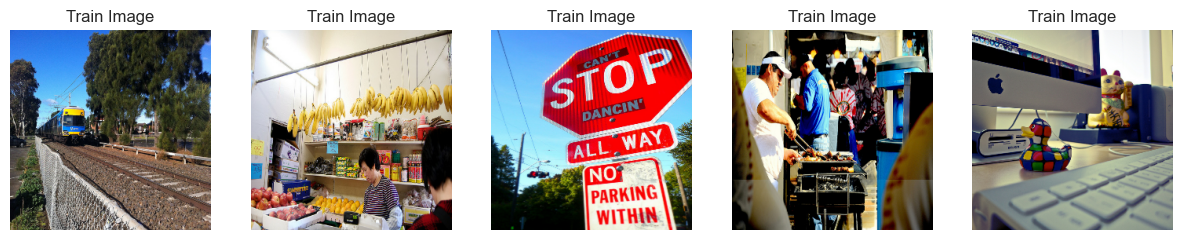

In [7]:
displayImagesFromDataset(train_set, "Train Image")

## Création des différents bruits 

In [6]:
def add_gaussian_noise(image, intensity=1.0, mean=0.0):
    stddev = 20.0 * intensity
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    image = tf.cast(image, tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    return tf.cast(noisy_image, tf.uint8)


def add_poisson_noise(image, intensity=1.0):
    image = tf.cast(image, tf.float32)
    lam = image * intensity + 1e-3  # on adapte lambda avec l’intensité
    noisy = tf.random.poisson([], lam=lam, dtype=tf.float32)
    noisy = tf.clip_by_value(noisy, 0.0, 255.0)
    return tf.cast(noisy, tf.uint8)


def add_salt_pepper_noise(image, intensity=1.0):
    prob = 0.02 * intensity
    image = tf.cast(image, tf.float32)
    rnd = tf.random.uniform(tf.shape(image), 0, 1)

    salt = tf.cast(rnd < prob / 2, tf.float32) * 255
    pepper = tf.cast(rnd > 1 - prob / 2, tf.float32) * 0
    mask = tf.cast((rnd >= prob / 2) & (rnd <= 1 - prob / 2), tf.float32)

    noisy_image = image * mask + salt + pepper
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    return tf.cast(noisy_image, tf.uint8)


def add_uniform_noise(image, intensity=1.0):
    range_val = 20.0 * intensity
    minval = -range_val
    maxval = range_val
    image = tf.cast(image, tf.float32)
    noise = tf.random.uniform(tf.shape(image), minval=minval, maxval=maxval, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    return tf.cast(noisy_image, tf.uint8)

### Affichage des différents bruits

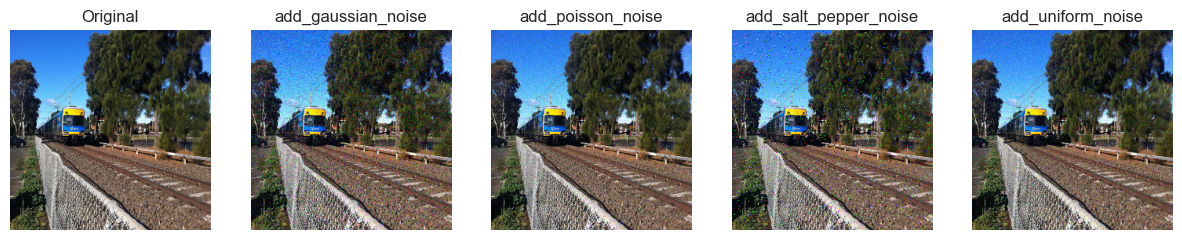

In [9]:
# Display the same image with different types of noise
def display_noisy_images(image, noise_functions):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, len(noise_functions) + 1, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    for i, noise_func in enumerate(noise_functions):
        noisy_image = noise_func(image)
        plt.subplot(1, len(noise_functions) + 1, i + 2)
        plt.imshow(noisy_image.numpy().astype("uint8"))
        plt.title(noise_func.__name__)
        plt.axis("off")

    plt.show()


# Display a sample image with different types of noise
sample_image = next(iter(train_set.take(1)))[0]  # Get the first image from the first batch
noise_functions = [add_gaussian_noise, add_poisson_noise, add_salt_pepper_noise, add_uniform_noise]
display_noisy_images(sample_image, noise_functions)

In [7]:
def random_noise(image):
    noise_type = tf.random.uniform([], 0, 4, dtype=tf.int32)

    def case0(): return add_gaussian_noise(image)

    def case1(): return add_salt_pepper_noise(image)

    def case2(): return add_uniform_noise(image)

    def case3(): return add_poisson_noise(image)

    return tf.switch_case(noise_type, branch_fns=[case0, case1, case2, case3])

## Préparation

In [8]:
noisy_train_set = train_set.map(lambda x: random_noise(x))
noisy_val_set = val_set.map(lambda x: random_noise(x))

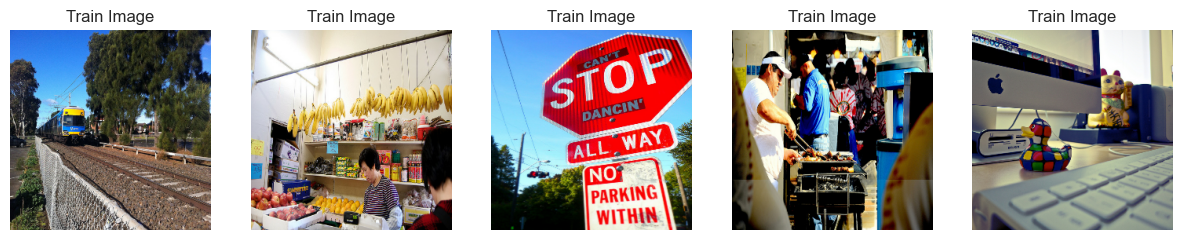

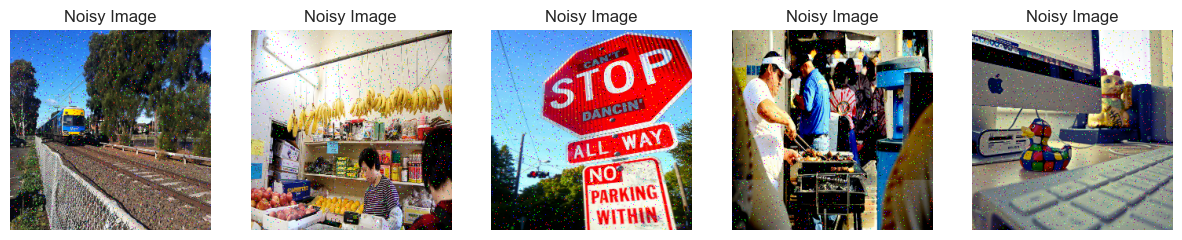

In [12]:
plt.figure(figsize=(15, 15))
for images in train_set.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Train Image")
        plt.axis("off")
plt.figure(figsize=(15, 15))
for images in noisy_train_set.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Noisy Image")
        plt.axis("off")

## Performance & pre processing

In [13]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# a_train_set = noisy_train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# a_val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

for image in noisy_train_set.take(1):
    print(f"Image shape: {image.shape}")

for image in noisy_val_set.take(1):
    print(f"Image shape: {image.shape}")

Image shape: (128, 256, 256, 3)
Image shape: (128, 256, 256, 3)


## Modélisation

In [9]:
# Configurations principales de nos modèles
IMG_SIZE = img_width
NB_EPOCHS_DENOISE = 10  # nombre epoch alogithme debruiter
BATCH_SIZE = 128  # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"  # sauvegarde du modele de debruitage
LATENT_DIM = 128

## Encodeur

In [39]:
encoder = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(LATENT_DIM, (3, 3), activation='relu', padding='same'),
])


## Décodeur

In [40]:
decoder = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])


In [41]:
from tensorflow.keras.models import Model


class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
            "latent_dim": self.latent_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        print("DEBUG CONFIG:", config)  # Ajoute ceci
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)


autoencoder = Autoencoder(encoder, decoder, LATENT_DIM)

In [20]:
# Définition de la fonction de perte combinée
from tensorflow.keras import backend as K

# Fonction de Loss custom pour comparer avec différents résultats
@tf.keras.utils.register_keras_serializable()
def combined_mse_ssim_loss(y_true, y_pred):
    # MSE pour la précision pixel par pixel
    mse_loss = K.mean(K.square(y_true - y_pred))

    # SSIM pour la préservation de la structure
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Combinaison pondérée
    alpha = 0.84  # Ajustez ce coefficient selon vos besoins
    return (1 - alpha) * mse_loss + alpha * ssim

In [42]:
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)
# autoencoder.summary()

encoder.summary()
decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrainement

In [43]:
# log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='L2_model_mse.keras', save_best_only=True)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [44]:
# Train the model
paired_train_set = tf.data.Dataset.zip((noisy_train_set, train_set))
paired_val_set = tf.data.Dataset.zip((noisy_val_set, val_set))

paired_train_set = paired_train_set.map(lambda noisy, clean: (tf.cast(noisy, tf.float32) / 255.0, clean / 255.0))
paired_val_set = paired_val_set.map(lambda noisy, clean: (tf.cast(noisy, tf.float32) / 255.0, clean / 255.0))

In [45]:
# Train the autoencoder
history = autoencoder.fit(
    paired_train_set,
    epochs=NB_EPOCHS_DENOISE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=paired_val_set,
    callbacks=[early_stopping, model_checkpoint]  #tensorboard_callback
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 0.0472 - val_loss: 0.0121
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - loss: 0.0107 - val_loss: 0.0086
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.0079 - val_loss: 0.0066
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.0069 - val_loss: 0.0063
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - loss: 0.0060 - val_loss: 0.0055
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - loss: 0.0059 - val_loss: 0.0055
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.0051 - val_loss: 0.0049
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.0049 - val_loss: 0.0053
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - loss: 0.0049 - val_loss: 0.0047


## Métriques

- Courbe d'apprentisssage

In [25]:
autoencoder = load_model('L2_model_mse_ssim.keras', custom_objects={'Autoencoder': Autoencoder})

DEBUG CONFIG: {'name': 'autoencoder', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1887298568784}, 'encoder': {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1887298568784}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 1887298568784}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding'

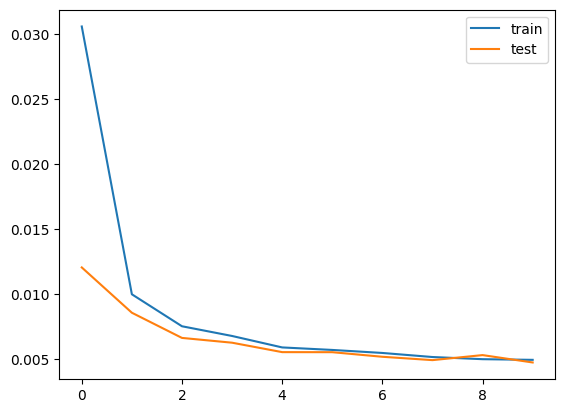

In [46]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

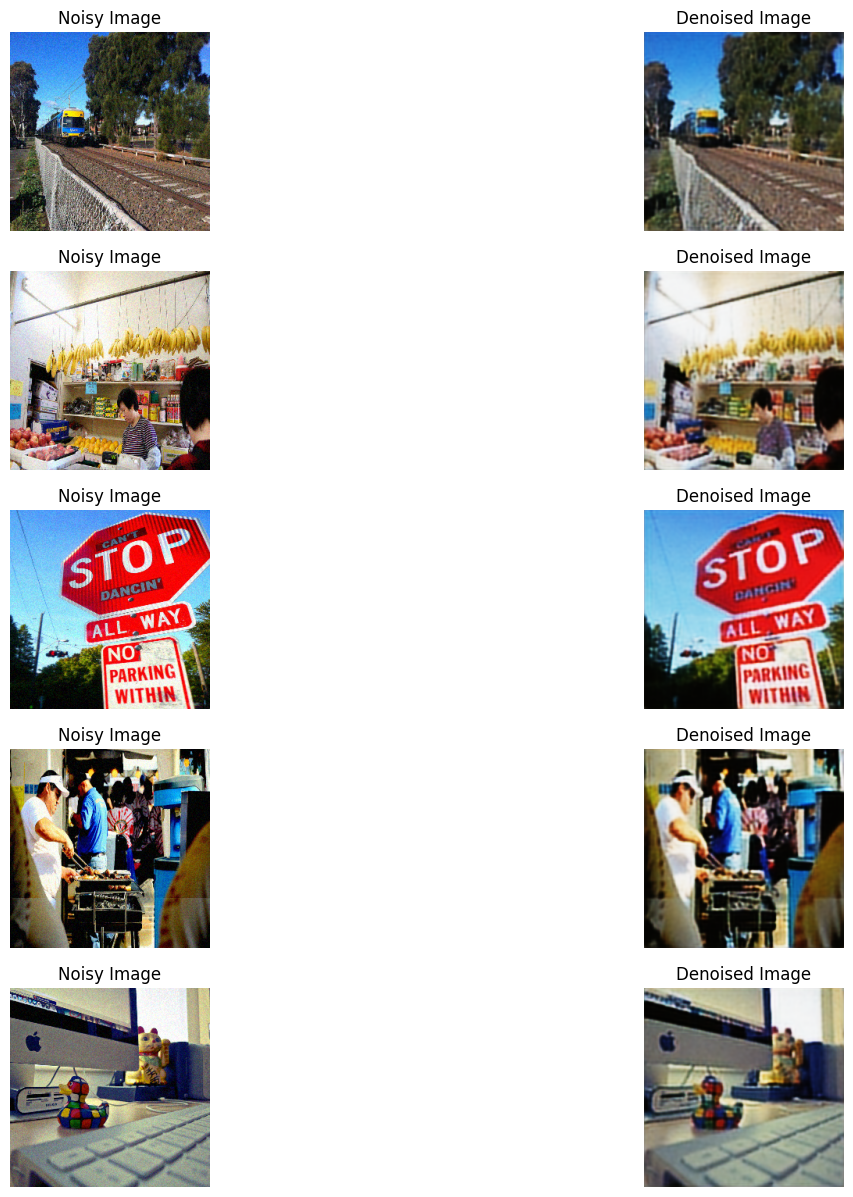

In [47]:
# Visualize noisy and denoised images side by side in columns
plt.figure(figsize=(15, 15))
for noisy_images_batch, clean_images_batch in paired_train_set.take(1):
    for i in range(5):  # Display 5 images
        # Display noisy image
        ax = plt.subplot(5, 2, 2 * i + 1)
        noisy_image = noisy_images_batch[i].numpy() * 255.0  # Scale back to [0, 255]
        plt.imshow(noisy_image.astype("uint8"))
        plt.title("Noisy Image")
        plt.axis("off")

        # Display denoised image
        denoised_image = autoencoder(noisy_images_batch[i:i + 1])  # Predict denoised image
        denoised_image = denoised_image[0].numpy() * 255.0  # Scale back to [0, 255]
        ax = plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(denoised_image.astype("uint8"))
        plt.title("Denoised Image")
        plt.axis("off")